# The business problem.

We will be determining a growth rate, and gathering the ages of the children.

The steps are:

1. Import the libraries
1. Join the data up
    1. Connect to the database
    1. Write the queries
    1. Check the data
    1. Read in the CSV files too
    1. Check the size
1. Join the data together
1. Feature engineer a growth rate from the population.
1. Write the cosine similarity function.
1. Apply to the ward of interest


## The data we have

* ONS data for the years 2001 - 2019 as mid-year estimates
    * The data are separated into 3 files which we will merge, and are at LSOA level.
* We will get two tables from the postGIS database, which is a postgresql database. (It's just a geographical database)
    * admin_boundaries.lsoa_boundaries_warwickshire_polygon (to match to the LSOA ONS data)
    * admin_boundaries.ward_boundaries_warwickshire_polygon

# Python libraries

Python uses libraries that are snippets of code that extend the main programming language function.

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.sql import  text
import os
import seaborn as sns

In [2]:
# Variables being used

## The string represenation of both the schema, and table of the lsoa_boundaries_table.
lsoa_boundaries_table = 'ons_geography.lsoa_2011_warwickshire_polygon'
## ward boundaries, string rep of both the schema and table
ward_boundaries_table = 'admin_boundary.ward_boundary_warwickshire_polygon'
## local_names_table 
local_names_table = 'statistics.imd_2015_warwickshire_polygon'

# local_names_backup = 'data/local_names.csv'

# ward of interest
ward = 'Abbey'
a = [1, 2, 10]
print(np.random.choice(a))

1


In [3]:
user = os.environ['WCC_USER'].lower()
pw = os.environ['POSTGIS_PW']
postgis = os.environ['POSTGIS_DB_REST_OF_CONN']
engine = create_engine('postgresql://' + user + ':' + pw + postgis,
                      connect_args={'sslmode': 'require'})
conn = engine.connect()


In [4]:
q = f"""
SELECT
lsoa_name.lsoa_code code,
local_name.wcc_name local_name,
ward.name AS "ward name"
FROM {lsoa_boundaries_table} lsoa_name
LEFT JOIN {local_names_table} local_name
ON lsoa_name.lsoa_code = local_name.lsoa_code
LEFT JOIN {ward_boundaries_table} ward
ON ST_Contains(ward.geom, ST_Centroid(lsoa_name.geom))
"""
local_names = pd.read_sql_query(q, con=conn)
local_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   code        339 non-null    object
 1   local_name  339 non-null    object
 2   ward name   339 non-null    object
dtypes: object(3)
memory usage: 8.1+ KB


In [5]:
local_names.head()

## Ward name changed to Abbey

,code,local_name,ward name
0,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre
1,E01031006,New Arley West & Old Arley,Arley and Whitacre
2,E01031007,New Arley South & Over Whitacre,Arley and Whitacre
3,E01031008,Ansley Common & Birchley Heath,Arley and Whitacre
4,E01031009,Atherstone - Canal & Outwoods,Atherstone Central


In [6]:
# Amendable section
ward = 'Abbey'
# Selecting the random choice
random_ward = np.random.choice(local_names['ward name'])
print(f'Ward pre-selected: {ward}\nRandom Ward: {random_ward}')

Ward pre-selected: Abbey
Random Ward: Tanworth-in-Arden


## A note on reproducibility and pseudorandomisation.

A random choice is required to make this an authentic randomised selection. However, you must also consider the reproducibility of your results a well.

Handily, numpy allows for a random seed.

For the above cell (Cell 6) - when we keep making a random choice it will keep changing. However, once we introduce np.random.seed with a number. It will always make the choices in a sequence.

___

### __Warning__

When you go back and re-run cells, for example the one above the random choice is no longer random. As notebooks work slightly different to standard programming environments. Once the cell below is ran pseudorandomness is introduced to all cells. Therefore running the cell above once again will result in random_ward being a fixed decision regardless of the amount of times it's ran thereafter.

Only once the kernel is restarted will cell 6 behave randomly again. It's something to keep in mind!

___


In [7]:
np.random.seed(1)
# It will treat this as a second choice.
pseudo_random_ward = np.random.choice(local_names['ward name'])
print(f'Ward pre-selected:{ward}\nRandom Ward is no longer random: {random_ward}\nPseudo Random Ward: {pseudo_random_ward}')

Ward pre-selected:Abbey
Random Ward is no longer random: Tanworth-in-Arden
Pseudo Random Ward: Water Orton


We check the shape of the dataset.

When we talk about the shape of the dataset we're talking about the dimensionality of the dataset.

In reality most datasets will follow a standard matrix format. (Rows and columns)

However, working at a local authority you are also likely to see tensor's if you make use of video/images. A tensor's shape will follow as 3 values returned.

In the below, we return tabular data.

In [8]:
print(local_names.shape)
print(f'The first value are rows: {local_names.shape[0]}\nThe second value are columns: {local_names.shape[1]}')

(339, 3)
The first value are rows: 339
The second value are columns: 3


## Loading in the dataset with 17 years data 2001 - 2017.

We want to load in the file, when Python loads anything in using Pandas it stores it in memory (the RAM of your computer). As you will see in a minute, the memory of large files can be problematic. So considering reducing memory is important.

In [9]:
ons_mid_year_df = pd.read_csv('data/lsoasyoaallyearst/lsoa_syoa_all_years_t.csv')
ons_mid_year_df.info()
# ons_mid_year_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590801 entries, 0 to 590800
Columns: 185 entries, LSOA11CD to f90
dtypes: int64(183), object(2)
memory usage: 833.9+ MB


In [10]:
print(ons_mid_year_df.shape)
print(f'The first value are rows: {ons_mid_year_df.shape[0]}\nThe second value are columns: {ons_mid_year_df.shape[1]}')

(590801, 185)
The first value are rows: 590801
The second value are columns: 185


We can also get a sense of the data using tail as well on the dataframe. It works in a similar fashion to head, but looks at the bottom of the dataframe instead.

In [11]:
ons_mid_year_df.tail()
# tail can also accept an input.
# ons_mid_year_df.tail(10)

,LSOA11CD,year,Pop_Total,m00,m01,m02,m03,m04,m05,m06,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
590796,W01001958,mid_2013,1322,4,6,5,4,4,4,2,...,3,2,3,4,4,1,2,4,1,3
590797,W01001958,mid_2014,1399,10,4,4,6,2,6,5,...,2,3,1,4,3,3,1,1,3,3
590798,W01001958,mid_2015,1481,3,14,5,6,10,4,7,...,7,1,4,1,2,3,2,1,1,3
590799,W01001958,mid_2016,1476,9,2,13,5,6,7,3,...,5,7,1,2,0,2,3,2,1,4
590800,W01001958,mid_2017,1513,9,8,3,9,4,9,7,...,3,3,7,1,1,0,3,5,2,4


## Merging data frames

We have so far created two dataframes. If you are familiar with SQL it's possible to do joins and merges on the dataframes as well. As you will have seen from above, it's not just possible to write SQL statements within Python when you use the right libraries, but pandas makes it incredibly easy to use similar functions of SQL within python itself.

The line below merges ons_mid_year_df with the local names.

We specify additional parameters:

* how - the type of merge we are doing. In this instance we only want to keep the matches.
* left_on - The name of the column in the left dataframe (local_names)
* right_on - The name of the column in the right dataframe (ons_mid_year_df)

In [12]:
df = local_names.merge(ons_mid_year_df, how='inner', left_on='code', right_on='LSOA11CD')
# We could drop the unnecessary column using method chaining
# df = local_names.merge(ons_mid_year_df, how='inner', left_on='code', right_on='LSOA11CD').drop('LSOA11CD', axis=1)

With the newly created dataframe (df) we will now check this to see if it has worked. We would expect to have 339 LSOA's present within Warwickshire, and 17 rows for each LSOA.

We would assume that the new columns are added to the new dataset.

Using `df.info()` gives us useful information.

In [13]:
# df.info(verbose=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5763 entries, 0 to 5762
Columns: 188 entries, code to f90
dtypes: int64(183), object(5)
memory usage: 8.3+ MB


We can now see that the memory usage has reduced. In this demo, we are going end to end with what could be several processes. Taking a dataset and reducing it down may be the only process you require python tools to do.

Although this touches a little on Data Engineering now, around storage.

In [14]:
print('Memory size is now over 100 times smaller = ', (ons_mid_year_df.memory_usage().sum() / df.memory_usage().sum()))

Memory size is now over 100 times smaller =  100.34658333998955


We could then drop more columns which aren't needed, by going back and method chaining ```.drop('LSOA11CD', axis=1)```

As you can see from the dataframe there are 5763 entries, those that can do quick maths will know that's 17 rows per 339 but we should check that assumption.

In [15]:
df = df.drop('LSOA11CD', axis=1)
print('Memory size is now over 100 times smaller = ', (ons_mid_year_df.memory_usage().sum() / df.memory_usage().sum()))

Memory size is now over 100 times smaller =  100.88034176201077


There are other useful methods that affect only columns within a dataframe. A column within a dataframe is called a series.

These methods can also be useful in checking the merge worked.

In [16]:
# you can access a dataframe with two methods
# df.code.value_counts() or
df['code'].value_counts()

E01031206    17
E01031231    17
E01031067    17
E01031289    17
E01031189    17
             ..
E01031156    17
E01031237    17
E01031118    17
E01031267    17
E01031209    17
Name: code, Length: 339, dtype: int64

In [17]:
df['code'].nunique()

339

In [18]:
## We also want to check the number of unique wards.
df['ward name'].nunique()

105

Finally, checking that the values you are both min/max could be helpful. If the assertion passes we can assume all figures are represented against all codes. Therefore for each LSOA we have 17 expected rows.

___
## Assertion Statements

Assertion statements are useful method for software testing, which is an additionally nice tool for testing assumptions about the data. In the below assertion test, we test if each LSOA has 17 rows, this is by testing that the minimum value count is equal to the maximum value count with the series code.

If the assertion test failed it would raise an error. In this example it would be that "Not all have 17 rows"

In [19]:
assert df['code'].value_counts().min() == df['code'].value_counts().max(), 'Not all have 17 rows'

## Raising an assertion error

As an example of raising an assertion error. We can consider a different column with population data for males of an age younger than 1. The minimum for the all the LSOA's is 0, and the maximum is 41.

If we implemented an assertion to say that we would expect the min and max of the column to equal it will raise an error and stop any further cells you are working from working. This can be really useful as it will point to errors in assumptions.

In [20]:
print(df['m00'].min(), df['m00'].max()) # min is 0 and max is 41
assert df['m00'].min() == df['m00'].max(), 'Expected Failure, the min and max don\'t match'

0 41


AssertionError: Expected Failure, the min and max don't match

As you can see from the above, it raises an AssertionError with the error text we assigned to the test.

In [21]:
## This box just shows error handling. So using the AssertionError from the above, we can deal with the error and still run code.
try:
    assert df['m00'].min() == df['m00'].max(), 'Expected Failure, the min and max don\'t match'
except:
    pass
    print('To run this code block it handled the error.')

To run this code block it handled the error.


___

## A note before we add 2018 and 2019

We are currently missing the Mid Year estimate for 2018 and 2019 respectively. It's worth adding them in now. [But there's an important issue! 🔥🚒🚒👨‍🚒👨‍🚒👩‍🚒👩‍🚒🧨🧨](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/methodologies/smallareapopulationestimatessummaryofmethodologyreviewandresearchupdate)

__TLDR;__ due to drift over the years, LSOA is not the preferred way of presenting the data, it fails to meet the standard, as national statistics. Patterns of variation and bias were also observed, by age, sex and geography.

## Adding in 2018 / 2019
Format of the data has changed, now switched to excel sheets, and female/male are separated over two different sheets.

Also, noting for 2019, update of code names which we want to keep, and that the table starts at row 5

In [22]:
female_pop_2018 = pd.read_excel('data/2018/2018.xlsx', sheet_name='Mid-2018 Females', skiprows=4, engine='openpyxl')
male_pop_2018 = pd.read_excel('data/2018/2018.xlsx', sheet_name='Mid-2018 Males', skiprows=4, engine='openpyxl')
female_pop_2019 = pd.read_excel('data/2019/2019.xlsx', sheet_name='Mid-2019 Females', skiprows=4, engine='openpyxl')
male_pop_2019 = pd.read_excel('data/2019/2019.xlsx', sheet_name='Mid-2019 Males', skiprows=4, engine='openpyxl')

/home/tfos1/lga-code/venv/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


We merge the local_names with each of the new tables we've just loaded.

In [23]:
female_pop_2018 = local_names.merge(female_pop_2018, how='inner', left_on='code', right_on='Area Codes')
male_pop_2018 = local_names.merge(male_pop_2018, how='inner', left_on='code', right_on='Area Codes')
female_pop_2019 = local_names.merge(female_pop_2019, how='inner', left_on='code', right_on='LSOA Code')
male_pop_2019 = local_names.merge(male_pop_2019, how='inner', left_on='code', right_on='LSOA Code')

We can then sense check what the new tables look like.

In [24]:
male_pop_2018

,code,local_name,ward name,Area Codes,Area Names,All Ages,0,1,2,3,...,81,82,83,84,85,86,87,88,89,90+
0,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,E01031005,North Warwickshire 005A,754,4,5,10,6,...,5,2,3,4,2,0,1,0,0,2
1,E01031006,New Arley West & Old Arley,Arley and Whitacre,E01031006,North Warwickshire 007A,753,6,7,9,5,...,3,6,2,2,2,1,1,0,1,9
2,E01031007,New Arley South & Over Whitacre,Arley and Whitacre,E01031007,North Warwickshire 007B,627,4,5,5,7,...,4,3,2,2,0,1,0,0,0,1
3,E01031008,Ansley Common & Birchley Heath,Arley and Whitacre,E01031008,North Warwickshire 005B,685,6,9,8,16,...,3,2,1,1,1,0,0,3,1,1
4,E01031009,Atherstone - Canal & Outwoods,Atherstone Central,E01031009,North Warwickshire 003A,1141,19,16,17,14,...,4,3,3,2,7,5,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,E01033252,Bridgetown North East & Golf Course,Tiddington,E01033252,Stratford-on-Avon 010F,622,2,2,5,5,...,6,1,7,4,4,4,4,5,3,3
335,E01033253,Leamington Town Centre - Regent Street,Clarendon,E01033253,Warwick 007H,998,12,7,5,8,...,1,0,0,1,1,0,0,0,2,2
336,E01033254,Chase Meadow,Aylesford,E01033254,Warwick 011G,807,14,10,13,12,...,1,1,1,0,3,4,0,0,0,1
337,E01033255,Kings Meadow & Longbridge,Aylesford,E01033255,Warwick 011H,1150,31,26,34,24,...,7,5,3,0,4,2,3,5,3,8


2018 and 2019 look different to one another. There's more columns in 2019.

In [25]:
male_pop_2019

,code,local_name,ward name,LSOA Code,LSOA Name,LA Code (2019 boundaries),LA name (2019 boundaries),LA Code (2020 boundaries),LA name (2020 boundaries),All Ages,...,81,82,83,84,85,86,87,88,89,90+
0,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,E01031005,North Warwickshire 005A,E07000218,North Warwickshire,E07000218,North Warwickshire,770,...,8,6,1,2,1,1,1,0,1,3
1,E01031006,New Arley West & Old Arley,Arley and Whitacre,E01031006,North Warwickshire 007A,E07000218,North Warwickshire,E07000218,North Warwickshire,752,...,6,2,5,1,0,1,1,1,1,7
2,E01031007,New Arley South & Over Whitacre,Arley and Whitacre,E01031007,North Warwickshire 007B,E07000218,North Warwickshire,E07000218,North Warwickshire,630,...,5,4,4,1,0,0,0,0,0,3
3,E01031008,Ansley Common & Birchley Heath,Arley and Whitacre,E01031008,North Warwickshire 005B,E07000218,North Warwickshire,E07000218,North Warwickshire,725,...,2,2,2,1,2,2,0,2,3,3
4,E01031009,Atherstone - Canal & Outwoods,Atherstone Central,E01031009,North Warwickshire 003A,E07000218,North Warwickshire,E07000218,North Warwickshire,1156,...,5,4,3,2,3,5,4,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,E01033252,Bridgetown North East & Golf Course,Tiddington,E01033252,Stratford-on-Avon 010F,E07000221,Stratford-on-Avon,E07000221,Stratford-on-Avon,627,...,14,8,2,6,4,2,3,3,3,4
335,E01033253,Leamington Town Centre - Regent Street,Clarendon,E01033253,Warwick 007H,E07000222,Warwick,E07000222,Warwick,1018,...,0,1,0,0,1,2,1,0,1,2
336,E01033254,Chase Meadow,Aylesford,E01033254,Warwick 011G,E07000222,Warwick,E07000222,Warwick,781,...,4,2,2,1,0,5,3,3,0,1
337,E01033255,Kings Meadow & Longbridge,Aylesford,E01033255,Warwick 011H,E07000222,Warwick,E07000222,Warwick,1175,...,2,7,4,1,2,4,4,4,6,8


### Tidy up 2018 and 2019 by dropping columns to only ones of interest.

In [26]:
female_pop_2018.drop(['Area Codes', 'Area Names', 'local_name', 'ward name'], axis=1, inplace=True)
male_pop_2018.drop(['Area Codes', 'Area Names', 'local_name', 'ward name'], axis=1, inplace=True)
female_pop_2019.drop(
    [
        'LSOA Code',
        'LSOA Name',
        'LA Code (2019 boundaries)',
        'LA name (2019 boundaries)',
        'LA Code (2020 boundaries)',
        'LA name (2020 boundaries)',
        'local_name',
        'ward name'
    ], axis=1, inplace=True)
male_pop_2019.drop(
    [
        'LSOA Code',
        'LSOA Name',
        'LA Code (2019 boundaries)',
        'LA name (2019 boundaries)',
        'LA Code (2020 boundaries)',
        'LA name (2020 boundaries)',
        'local_name',
        'ward name'
    ], axis=1, inplace=True)

In [27]:
male_pop_2018

,code,All Ages,0,1,2,3,4,5,6,7,...,81,82,83,84,85,86,87,88,89,90+
0,E01031005,754,4,5,10,6,7,12,19,9,...,5,2,3,4,2,0,1,0,0,2
1,E01031006,753,6,7,9,5,8,12,7,8,...,3,6,2,2,2,1,1,0,1,9
2,E01031007,627,4,5,5,7,6,4,10,7,...,4,3,2,2,0,1,0,0,0,1
3,E01031008,685,6,9,8,16,11,8,14,7,...,3,2,1,1,1,0,0,3,1,1
4,E01031009,1141,19,16,17,14,19,18,15,10,...,4,3,3,2,7,5,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,E01033252,622,2,2,5,5,5,3,2,5,...,6,1,7,4,4,4,4,5,3,3
335,E01033253,998,12,7,5,8,7,6,1,2,...,1,0,0,1,1,0,0,0,2,2
336,E01033254,807,14,10,13,12,11,16,11,26,...,1,1,1,0,3,4,0,0,0,1
337,E01033255,1150,31,26,34,24,31,14,33,22,...,7,5,3,0,4,2,3,5,3,8


In [28]:
male_pop_2019

,code,All Ages,0,1,2,3,4,5,6,7,...,81,82,83,84,85,86,87,88,89,90+
0,E01031005,770,5,9,5,8,7,8,10,19,...,8,6,1,2,1,1,1,0,1,3
1,E01031006,752,8,7,6,8,5,10,11,8,...,6,2,5,1,0,1,1,1,1,7
2,E01031007,630,6,4,4,5,5,10,4,10,...,5,4,4,1,0,0,0,0,0,3
3,E01031008,725,10,8,12,6,19,15,8,15,...,2,2,2,1,2,2,0,2,3,3
4,E01031009,1156,15,18,12,16,15,16,19,18,...,5,4,3,2,3,5,4,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,E01033252,627,7,1,2,7,6,3,2,3,...,14,8,2,6,4,2,3,3,3,4
335,E01033253,1018,2,12,11,7,4,4,5,2,...,0,1,0,0,1,2,1,0,1,2
336,E01033254,781,11,11,12,10,8,13,14,10,...,4,2,2,1,0,5,3,3,0,1
337,E01033255,1175,25,31,26,29,25,29,15,31,...,2,7,4,1,2,4,4,4,6,8


# The first introduction to functions.

A function can either be a small bit of code that you want to specifically use frequently or more than once. Functions tend to be reuseable bits of code that can be applied more than once and save space.

In the particular example the formatting of the 2018 and 2019 data sources is different to the dataset containing 17 years of data. We therefore want to match 2018 and 2019 to the dataset containing 17 years of data.

The below function allows us to create the same naming pattern.

In [29]:
def rename_columns(dataframe, sex):
    """
    A function that renames columns, specific to the tasks of ages. in place.
    
    Params:
    dataframe : takes a dataframe that expects ages columns
    sex : expects a single letter of either 'M' or 'F'

    Once applied it uses inplace, which will affect the dataframe directly.    
    """
    new_dictionary = {x: sex.lower() + '0' + str(x) if x < 10 else sex.lower() + str(x) for x in range(90)}
    new_dictionary['All Ages'] = sex + '_sex_All Ages'
    new_dictionary['90+'] = sex.lower() + '90'
    dataframe.rename(columns=new_dictionary, inplace=True)

We can now apply the function to the dataframes. 

In [30]:
rename_columns(female_pop_2018, 'f')
rename_columns(male_pop_2018, 'm')
rename_columns(female_pop_2019, 'f')
rename_columns(male_pop_2019, 'm')

And then we can bring female and male population data for each year together.

In [31]:
pop_2018 = female_pop_2018.merge(male_pop_2018, left_on='code', right_on='code')
pop_2019 = female_pop_2019.merge(male_pop_2019, left_on='code', right_on='code')

## Creating new columns

Pandas will allow you to create new columns with constant values simply. It also creates columns simply by adding them together, or whichever is your preferred operation that you require.

In [32]:
# Assigning a column with a single value is also possible.
pop_2018['year'] = 'mid_2018'
pop_2018['Pop_Total'] = pop_2018['f_sex_All Ages'] + pop_2018['m_sex_All Ages']
pop_2019['year'] = 'mid_2019'
pop_2019['Pop_Total'] = pop_2019['f_sex_All Ages'] + pop_2019['m_sex_All Ages']

You can also slice a dataframe as well so you only have a view of certain columns. This is done by passing in a list into the dataframe columns. The below code does not affect pop_2018 but is simply returning some sense of the values. It could be saved as a value. (I would recommend using .copy() at the end of it too)

In [33]:
## demonstrate a sliced dataframe
pop_2018[['year', 'Pop_Total', 'f_sex_All Ages', 'm_sex_All Ages']]

,year,Pop_Total,f_sex_All Ages,m_sex_All Ages
0,mid_2018,1469,715,754
1,mid_2018,1502,749,753
2,mid_2018,1284,657,627
3,mid_2018,1397,712,685
4,mid_2018,2277,1136,1141
...,...,...,...,...
334,mid_2018,1309,687,622
335,mid_2018,1806,808,998
336,mid_2018,1608,801,807
337,mid_2018,2378,1228,1150


Since we don't need certain columns within the data we can then also drop these.

In [34]:
pop_2018.drop(['f_sex_All Ages', 'm_sex_All Ages'], axis=1, inplace=True)
pop_2019.drop(['f_sex_All Ages', 'm_sex_All Ages'], axis=1, inplace=True)

In [35]:
pop_2018.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339 entries, 0 to 338
Data columns (total 185 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   code       object
 1   f00        int64 
 2   f01        int64 
 3   f02        int64 
 4   f03        int64 
 5   f04        int64 
 6   f05        int64 
 7   f06        int64 
 8   f07        int64 
 9   f08        int64 
 10  f09        int64 
 11  f10        int64 
 12  f11        int64 
 13  f12        int64 
 14  f13        int64 
 15  f14        int64 
 16  f15        int64 
 17  f16        int64 
 18  f17        int64 
 19  f18        int64 
 20  f19        int64 
 21  f20        int64 
 22  f21        int64 
 23  f22        int64 
 24  f23        int64 
 25  f24        int64 
 26  f25        int64 
 27  f26        int64 
 28  f27        int64 
 29  f28        int64 
 30  f29        int64 
 31  f30        int64 
 32  f31        int64 
 33  f32        int64 
 34  f33        int64 
 35  f34        int64 
 36  f35        int6

With dataframes represention correct, we will now merged them to local names.

In [36]:
pop_2018 = local_names.merge(pop_2018, left_on='code', right_on='code')
pop_2019 = local_names.merge(pop_2019, left_on='code', right_on='code')

## Concatenating the dataframes together.

We now want to concatenate all the dataframes together. We will do this simply by passing a list of dataframes we want to merge together.

This will match them row wise, adding the rows to the bottom of the others.

We will call the new dataframe all_years.

In [37]:
all_years = pd.concat([df, pop_2018, pop_2019])

In [38]:
all_years

,code,local_name,ward name,year,Pop_Total,m00,m01,m02,m03,m04,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
0,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2001,1416,9,12,9,9,15,...,6,3,3,6,3,3,5,3,0,3
1,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2002,1381,9,7,7,10,10,...,4,7,1,7,4,1,1,1,1,5
2,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2003,1464,10,6,6,7,10,...,4,3,7,4,7,1,1,1,1,14
3,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2004,1472,14,11,9,13,9,...,2,5,3,5,1,6,2,1,1,6
4,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2005,1430,9,15,12,9,11,...,5,2,5,3,4,1,4,2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,E01033252,Bridgetown North East & Golf Course,Tiddington,mid_2019,1321,7,1,2,7,6,...,15,13,1,5,5,6,1,2,3,12
335,E01033253,Leamington Town Centre - Regent Street,Clarendon,mid_2019,1829,2,12,11,7,4,...,1,2,4,2,0,5,2,5,3,13
336,E01033254,Chase Meadow,Aylesford,mid_2019,1572,11,11,12,10,8,...,2,1,1,0,0,0,0,0,1,1
337,E01033255,Kings Meadow & Longbridge,Aylesford,mid_2019,2413,25,31,26,29,25,...,3,6,6,2,2,2,2,2,2,18


# Did you notice the notice the error?


* Look at the index, the tail stats that the rows index is 338, but we can see we have 6441 rows any ideas as to why?

This is where it is important to know something regarding indexes. In this case the index is not unique.

We are going to make use of indexes later that will require unique values. Therefore, it's best to get an idea of how to reset the index.

Indexes will also come up further.

____

In [39]:
# the inplace parameter allows you to return without the need to reassign the value.
## using inplace is similar to:
## all_years = all_years.reset_index(drop=True)
all_years.reset_index(drop=True, inplace=True)

In [40]:
all_years

,code,local_name,ward name,year,Pop_Total,m00,m01,m02,m03,m04,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
0,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2001,1416,9,12,9,9,15,...,6,3,3,6,3,3,5,3,0,3
1,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2002,1381,9,7,7,10,10,...,4,7,1,7,4,1,1,1,1,5
2,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2003,1464,10,6,6,7,10,...,4,3,7,4,7,1,1,1,1,14
3,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2004,1472,14,11,9,13,9,...,2,5,3,5,1,6,2,1,1,6
4,E01031005,"New Arley East, Hill Top & Ansley",Arley and Whitacre,mid_2005,1430,9,15,12,9,11,...,5,2,5,3,4,1,4,2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6436,E01033252,Bridgetown North East & Golf Course,Tiddington,mid_2019,1321,7,1,2,7,6,...,15,13,1,5,5,6,1,2,3,12
6437,E01033253,Leamington Town Centre - Regent Street,Clarendon,mid_2019,1829,2,12,11,7,4,...,1,2,4,2,0,5,2,5,3,13
6438,E01033254,Chase Meadow,Aylesford,mid_2019,1572,11,11,12,10,8,...,2,1,1,0,0,0,0,0,1,1
6439,E01033255,Kings Meadow & Longbridge,Aylesford,mid_2019,2413,25,31,26,29,25,...,3,6,6,2,2,2,2,2,2,18


We then perform a similar check as we had done previously. Asserting that each LSOA has a count of 19 years each.

In [41]:
assert all_years['code'].value_counts().min() == all_years['code'].value_counts().max(), 'Not all have 19 years'
print('data okay')

data okay


## Column clean up

As you will note from the above the year column is not a numerical value as it has mid_ ahead of the number, since we need the year for later. We need to clean up the values in the column and change the type.

In [42]:
## Tidy up the year column - you can perform operations against the column such as string removal/text clean up.
## We are overwriting the column, which is a one time use.
## It may be worth calling it all_years['year_cleaned'].
## For this demo it will be fine as we will only run it the once.
all_years['year'] = all_years['year'].str[4:]

Let's check the column and how it looks.

In [43]:
all_years['year']

0       2001
1       2002
2       2003
3       2004
4       2005
        ... 
6436    2019
6437    2019
6438    2019
6439    2019
6440    2019
Name: year, Length: 6441, dtype: object

From the output above we can see the ```dtype: object```. In pandas this dtype is the catch all type. Think of it as treating the numbers as text still.

To recognise the figures as integers. We need to cast them as the correct type.

In [44]:
all_years['year'] = all_years['year'].astype('int')
all_years['year']

0       2001
1       2002
2       2003
3       2004
4       2005
        ... 
6436    2019
6437    2019
6438    2019
6439    2019
6440    2019
Name: year, Length: 6441, dtype: int64

## Further manipulation of the data.

Now that we are happy with the data and it's types. We now need to get the data to ward level. Currently the data are only at LSOA level.

We'll just get a quick sense check of the work. Since we are looking at `Abbey` for the demo we can sort the values on ward name just to reacquaint ourselves with the data.

In [45]:
all_years.sort_values(['ward name'])

,code,local_name,ward name,year,Pop_Total,m00,m01,m02,m03,m04,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
6348,E01031257,Kenilworth - Abbey East,Abbey,2019,1405,9,8,11,7,10,...,4,5,6,10,5,7,5,2,0,26
4165,E01031256,Kenilworth - Abbey Fields,Abbey,2001,1557,3,6,7,6,9,...,11,6,0,3,7,4,3,4,3,9
4166,E01031256,Kenilworth - Abbey Fields,Abbey,2002,1557,4,3,6,9,3,...,12,7,4,1,8,7,8,5,4,3
4167,E01031256,Kenilworth - Abbey Fields,Abbey,2003,1562,1,7,4,7,9,...,14,10,7,4,1,3,7,4,1,1
4168,E01031256,Kenilworth - Abbey Fields,Abbey,2004,1573,1,3,4,6,8,...,11,12,12,7,6,1,3,5,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,E01031204,Wootton Wawen,Wotton Wawen,2002,1238,3,4,4,7,3,...,11,12,5,6,6,3,8,3,0,3
3298,E01031204,Wootton Wawen,Wotton Wawen,2001,1250,3,3,3,3,3,...,9,6,6,6,3,6,6,6,4,16
3161,E01031195,Claverdon,Wotton Wawen,2017,2200,8,8,4,10,17,...,8,9,10,5,9,7,7,5,4,27
3159,E01031195,Claverdon,Wotton Wawen,2015,2180,7,7,17,9,8,...,11,4,7,8,6,6,7,3,8,30


## Groupby and aggregation

We now want to group the data by wards and also by year.

With pandas you can pass either a single argument or a list of arguments in the order to which you want to perform the groupby.

When performing this operation, it will create a multi-index to the data.

The first index being `ward name` and the second being `year`.

Finally, we aggregate the numbers up by the groupby.

In [46]:
## essentially a pivot
ward_df = all_years.copy().groupby(['ward name', 'year']).sum()

In [47]:
ward_df

Pop_Total  m00  m01  m02  m03  m04  m05  m06  m07  m08  \
ward name    year                                                           
Abbey        2001      14790   69   78   91   87   91   98   89   86   93   
             2002      14812   81   70   65   74   90   80   82   97   98   
             2003      14997   72   74   70   65   77   88   81   85   98   
             2004      14966   76   74   69   71   71   88   93   75   74   
             2005      15081   85   81   67   69   78   68   85   90   69   
...                      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Wotton Wawen 2015       3504    9    9   21   12   12   26   27   11   15   
             2016       3512   11    7   11   22   12   14   21   26   11   
             2017       3551    9   12    6   12   24   12   11   21   26   
             2018       3545   17    9   14    9   14   24   12   13   21   
             2019       3580   10   17   10   12   11   18   25   13   13   

                   ...  f81  f82  f83  f84  f85  f86  f87  f88  f89  f90  
ward name    year  ...                                                    
Abbey        2001  ...   75   51   37   38   52   46   37   28   28   95  
             2002  ...   63   67   46   37   43   40   42   42   38  113  
             2003  ...   64   59   61   44   29   30   36   36   38  122  
             2004  ...   56   60   60   64   42   33   30   40   32   97  
             2005  ...   49   47   53   51   59   34   27   25   32   98  
...                ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
Wotton Wawen 2015  ...   20   14   15   13   10   14    9    5    9   47  
             2016  ...   18   17   14   17   10    9   14    8    4   48  
             2017  ...   21   16   19   13   14   10    9   12    7   39  
             2018  ...   21   22   16   19   11   15   10    8   12   33  
             2019  ...   20   19   19   17   14   10   11    9    8   47  

[1995 rows x 183 columns]

## Let's access the multi-index

We can make use of the multi-index and hopefully show why this will be useful.

Remember previously at the top we declared a variable called ward. We could use the name of a ward and pass that in to locate that ward in the multi-index.

This will then return a dataframe which has the year as the index.





In [48]:
ward = 'Abbey'
abbey_ward = ward_df.loc[ward]
display(abbey_ward)

,Pop_Total,m00,m01,m02,m03,m04,m05,m06,m07,m08,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
year,,,,,,,,,,,,,,,,,,,,,
2001,14790,69,78,91,87,91,98,89,86,93,...,75,51,37,38,52,46,37,28,28,95
2002,14812,81,70,65,74,90,80,82,97,98,...,63,67,46,37,43,40,42,42,38,113
2003,14997,72,74,70,65,77,88,81,85,98,...,64,59,61,44,29,30,36,36,38,122
2004,14966,76,74,69,71,71,88,93,75,74,...,56,60,60,64,42,33,30,40,32,97
2005,15081,85,81,67,69,78,68,85,90,69,...,49,47,53,51,59,34,27,25,32,98
2006,15353,78,88,80,74,76,67,69,84,88,...,62,46,44,50,52,57,31,28,20,99
2007,15499,90,79,98,84,72,72,69,77,88,...,49,57,46,41,49,40,45,31,21,101
2008,15693,108,95,85,99,88,70,74,72,76,...,61,46,52,45,41,41,37,39,25,96
2009,15755,101,109,92,87,93,88,66,76,67,...,58,57,41,54,37,36,37,38,35,106


# Moving towards a growth rate.

Now that the data is starting to look like it's making sense, we can now look at generating a growth rate.

##  Population Mid-Year Estimates Growth Linear Regression

The ONS mid-year estimates are the population estimates for Great Britain, but we will be looking at Warwickshire's mid year estimates, and applying linear regression to evaluate how the population has changed over the a 19 years period from 2001 - 2019.

The equation for a straight line can be written as:

$$ y = w_0 + x + w_1$$

This can also be written in other forms such as $ y = mx + c $. $w0$ is the slope of the line, $w1$ is the intersect of the $y$-axis. We can absorb $w1$ into $w0$ to write a single matrix expression by defining:

$$\mathbf{w} = \begin{bmatrix} w_0 & w1\end{bmatrix},  \mathbf{X} = \begin{bmatrix} x_0 & 1 \\ x_1 & 1 \\ \vdots \\ x_n & 1 \end{bmatrix}$$

Imagine there is only one value in $\mathbf{X}$, which we'll denote $x_0$:

$$ y =  \begin{bmatrix} w_0 & w1 \end{bmatrix} \begin{bmatrix} x_0 \\ 1 \end{bmatrix} = w_0 x + 1w_1$$

This is the same as the first equation. Notice that we had to transpose $x$ for this to work. In our data, $x$ is the years over which we would like to regress, and $y$ is the population.

In [50]:
X = np.vstack([np.array([abbey_ward.index[x] for x in range(len(abbey_ward.index))]), np.ones(len(abbey_ward.index))])
y = np.array([x for x in abbey_ward['Pop_Total']])
w0, w1 = np.linalg.lstsq(X.T, y, rcond=None)[0]
## w0 is where the line crosses the y-axis. (
# The intecept which will interpret as a growth rate)
# w1 won't be used later, but we will use it for plotting.
# w1 is the slope (how steep the line is)
print(w0, w1)

111.61578947368398 -208535.47368421


# Visualise it to make sense of the intuition

We can show the above with the line of best fit. In the below `_` represents an anonymous variable that we will be using.

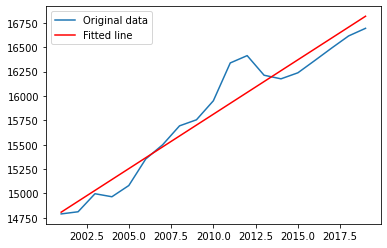

In [65]:
import matplotlib.pyplot as plt
_ = plt.plot(abbey_ward.index, abbey_ward['Pop_Total'], label='Original data', markersize=10)
_ = plt.plot(abbey_ward.index, w0*abbey_ward.index + w1, 'r', label='Fitted line')
_ = plt.legend()
plt.show()

## Using the intercept as the growth rate.

We will use the intercept (w0) as the growth rate. As stated in the original purpose, we are looking for a number that represents the population growth rate and this could be used to gain a sense of a similar sized area of a given amount of years.

In general, it is better to approach linear regression with several years of data, but for a line of best fit the minimum amount of years are 5.

Additionally, you may not always want to use 19 years worth of data, it may be you want to use 10, perhaps an area has had rapid growth.

As data grows you may also want to only take the last 20 years for instance. Or the last 100 events. It makes that the function only deals with the most recent ones, and then works backwards too.

We will write a function to take into account the data frame, the name of the ward and the amount of years we would want to look at.

In [59]:
## Write a cleaner function

def get_growth_rate(df, ward_name, years):
    """ Returns the growth rate for a given ward_name and for a given period over
    a multi-indexed df, which should follow an index of (ward_name, years).
    
    Params:
    df: The dataframe that has been pivoted with code  as the index
    ward_name: The ward_name this is the name given to the ward.
    years: specifying the years.
    
    This could be extended to accept a fourth optional argument.
    """
    if years < 5:
        raise ValueError("It's not useful to plot a linear regression with less than five points.")
    years += 1
    df = df.loc[(ward_name,)].iloc[[-x for x in range(1, years)]]
    # Correct the index and correct the assertion.
#     df.sort_index(inplace=True)
    display(df)
    X = np.vstack([np.array([df.index[x] for x in range(len(df.index))]), np.ones(len(df.index))])
    y = np.array([x for x in df['Pop_Total']])
    w0, w1 = np.linalg.lstsq(X.T, y, rcond=None)[0]
    return w0

# Let's use c as the y-intercept for this approach and assert that both y-intercepts are equal.
c = get_growth_rate(ward_df, ward, 19)

,Pop_Total,m00,m01,m02,m03,m04,m05,m06,m07,m08,...,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90
year,,,,,,,,,,,,,,,,,,,,,
2019,16693,87,77,98,91,88,83,86,89,84,...,49,60,58,46,39,48,24,38,26,144
2018,16615,88,102,89,86,97,91,86,84,101,...,68,56,55,46,49,27,42,30,31,134
2017,16491,99,94,96,99,104,86,79,100,84,...,61,49,46,52,31,44,35,34,24,139
2016,16363,94,91,99,108,101,77,104,85,90,...,54,52,54,28,46,34,38,28,33,136
2015,16237,102,92,113,107,93,106,85,98,77,...,50,58,32,51,37,35,31,36,21,145
2014,16175,80,112,106,97,114,90,93,79,90,...,55,36,48,40,44,33,41,24,30,144
2013,16212,103,100,100,106,108,101,84,93,84,...,34,56,40,55,33,44,29,32,25,150
2012,16413,108,106,106,104,116,87,93,89,82,...,58,46,57,47,47,32,38,38,28,137
2011,16338,114,112,108,128,99,93,94,83,63,...,41,62,53,48,37,48,36,31,28,122


## Testing the linear growth rate
We can make assertion that the approach we used to visualise the data and the function we've created work the same on the y-intercept.

Do we all agree the function has been written correctly?

As we're interest in ensuring that the y-intercept are the same. 
Let's assert that c = w0 which it should, because we have performed the same approach!

In [54]:
# Let's assume that c == w0 because they should be!
assert c == w0, f'Assertion is incorrect - slopes differ {c}, {w0}'

AssertionError: Assertion is incorrect - slopes differ 111.61578947368758, 111.61578947368398

# The assertion above is incorrect as you can see

This is a very very minor issue, with population growth however if this was high transactional data, this could be money lost, or a major error.

We will correct it. 

In [56]:
## Write a cleaner function

def get_growth_rate(df, lsoa_code, years):
    """ Returns the growth rate for a given lsoa_code and for a given period over a pivoted df
    
    Params:
    df: The dataframe that has been pivoted with code  as the index
    lsoa_code: The lsoa_code
    years: specifying the years.
    
    This could be extended to accept a fourth optional argument.
    """
    if years < 5:
        raise ValueError("It's not useful to plot a linear regression with less than five points.")
    years += 1
    df = df.loc[(lsoa_code,)].iloc[[-x for x in range(1, years)]]
    # Correct the index and correct the assertion.
    df.sort_index(inplace=True)
#     display(df)
    X = np.vstack([np.array([df.index[x] for x in range(len(df.index))]), np.ones(len(df.index))])
    y = np.array([x for x in df['Pop_Total']])
    w0, w1 = np.linalg.lstsq(X.T, y, rcond=None)[0]
    return w0

# Let's assign the function to a slope.
c1 = get_growth_rate(ward_df, ward, 19)

In [57]:
assert c1 == w0, f'Assertion is incorrect - slopes differ {c1}, {w0}'

In [ ]:
# Finally let's build the dataframe which will have the aggregation
# growth_rate = [get_growth_rate(ward_df, x, 19) for x in ward_df.index]
growth_rate = [get_growth_rate(ward_df, x, 5) for x in ward_df.index.get_level_values(0).unique()]
age_0 = []

In [ ]:
len(growth_rate)

In [ ]:
ages = all_years.copy().groupby(['ward name']).sum()

In [ ]:
ages.loc['Abbey Ward', ['m00', 'm01', 'm02', 'f00', 'f01', 'f02']]

In [ ]:
ages.loc['Abbey Ward', ['m00', 'm01', 'm02']]
test = pd.DataFrame(ages, columns=['m00', 'm01', 'm02'])
test['growth rate'] = growth_rate
test.index = ward_name
test.head()

In [ ]:
test.info()

## Cosine Similarity Function

In [ ]:
def cos_sim(ages_growth, target_id, k):
    """Take in the dataframe"""
    u = ages_growth.loc[target_id].to_numpy()
    df = pd.DataFrame(columns={'cosine_similarity'}, index=ages_growth.index)
    for index in ages_growth.index:
        v = ages_growth.loc[index].to_numpy()
        cosine_similarity = np.dot(u, v) / (np.linalg.norm(u, ord=2) * np.linalg.norm(v, ord=2))
        df.loc[index] = cosine_similarity
    print('Best 3')
    display(df[df.index != target_id].sort_values(by='cosine_similarity', ascending=False)[:k])
    print('Worst 3')
    display(df[df.index != target_id].sort_values(by='cosine_similarity', ascending=True)[:k])
    return df[df.index != target_id].sort_values(by='cosine_similarity', ascending=False)[:k].index.to_list()

In [ ]:
cos_sim(test, 'Abbey Ward', 3)

# Best 3

In [ ]:
test.loc[['Abbey Ward', 'New Bilton Ward', 'Warwick Saltisford Ward', 'Arbury Ward']]

# Worst 3

In [ ]:
test.loc[['Abbey Ward', "Bishop's Tachbrook Ward", "Quinton Ward", 'Wellesbourne West Ward']]